In [49]:
import numpy as np
import cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 

In [50]:
rutaDogsTrain = 'cat_dog_100/train/dog'
rutaDogsTest = 'cat_dog_100/test/dog'
rutaCatsTrain = 'cat_dog_100/train/cat'
rutaCatsTest = 'cat_dog_100/test/cat'

In [51]:
from os import walk

dogTrain = []
dogTest = []
catTest = []
catTrain = []
for (dirpath, dirnames, filenames) in walk(rutaDogs):
    dogTrain.extend(filenames)
    
for (dirpath, dirnames, filenames) in walk(rutaDogsTest):
    dogTest.extend(filenames)

for (dirpath, dirnames, filenames) in walk(rutaCatsTest):
    catTest.extend(filenames)

for (dirpath, dirnames, filenames) in walk(rutaCatsTrain):
    catTrain.extend(filenames)

In [52]:
print(f'{rutaDogs}/{dogTrain[0]}')

cat_dog_100/train/dog/dog.10000.jpg


In [144]:
tamano = 500
sizeVentana = 32
tamano = int(tamano/sizeVentana)*sizeVentana

In [54]:
def recorta_imagen(imagen, n):
    """
    Esta función recibe una imagen y un tamaño n y recorta la imagen de tal manera que el número final de filas/columnas 
    sea múltiplo de n. La funció debe recortar las filas de la derecha/abajo.
    """
    size = np.min([int(imagen.shape[0]/n)*n, int(imagen.shape[1]/n)*n])
    return imagen[:size, :size]

In [55]:
def resize_image(imagen, sizeVentana, tamano, recorta=False):
    if(recorta): imagen = recorta_imagen(imagen, sizeVentana)
    imagen2 = cv2.resize(imagen, [tamano,tamano])
    return imagen2

In [56]:
def ventana_a_decimal(ventana_binario):
    return ventana_binario[0,0]*2**7+ventana_binario[0,1]*2**6+ventana_binario[0,2]*2**5+ventana_binario[1,2]*2**4+ventana_binario[2,2]*2**3+ventana_binario[2,1]*2**2+ventana_binario[2,0]*2+ventana_binario[1,0]

In [57]:
def transforma_bloque(celda):
    celda_ampliada = cv2.copyMakeBorder(celda, 1, 1, 1, 1, cv2.BORDER_REPLICATE)
    celda2 = np.empty(celda.shape)
    for i in range(1, celda.shape[0]+1):
        for j in range(1, celda.shape[1]+1):
            ventana = celda_ampliada[i-1:i+2, j-1:j+2]
            ventana2 = np.zeros(ventana.shape)
            pixel_central = ventana[1,1]
            ventana2[ventana>pixel_central] = 1
            celda2[i-1,j-1] = ventana_a_decimal(ventana2)
    return celda2

In [58]:
def transforma_imagen(imagen, sizeVentana, tamano):
    imagen = resize_image(imagen, sizeVentana, tamano, True)
    #imagen2 = np.zeros(imagen.shape)
    caracteristicas = []
    a = int(imagen.shape[0]/sizeVentana)
    for i in range(a):
        for j in range(a):
            celda = imagen[i*sizeVentana:(i+1)*sizeVentana,j*sizeVentana:(j+1)*sizeVentana]
            nueva_celda = transforma_bloque(celda)
            #imagen2[i*sizeVentana:(i+1)*sizeVentana,j*sizeVentana:(j+1)*sizeVentana] = nueva_celda
            caracteristicas.append(cv2.calcHist([np.uint8(nueva_celda)], [0], None, [256], [0, 256]).ravel())
    return np.concatenate(caracteristicas)

In [59]:
n = 2
imagen = cv2.imread(f'{rutaDogs}/{dogTrain[n]}',0)
caracteristicas = transforma_imagen(imagen, sizeVentana, tamano)
print(caracteristicas)
print(caracteristicas.shape)
cv2.imshow(f'{dogTrain[n]}', imagen)
cv2.imshow(f'{dogTrain[n]}_transformada', np.uint8(imagen2))
cv2.waitKey(0)
cv2.destroyAllWindows()

[37.  0.  5. ...  0.  0.  3.]
(246016,)


In [145]:
X = []
for i in tqdm(range(len(dogTrain)), desc = "Perros", colour = '#FF88F8'):
    imagen = cv2.imread(f'{rutaDogsTrain}/{dogTrain[i]}',0)
    caracteristicas = transforma_imagen(imagen, sizeVentana, tamano)
    X.append(caracteristicas)

for i in tqdm(range(len(catTrain)), desc = "Gatos", colour = '#88FFDD'):
    imagen = cv2.imread(f'{rutaCatsTrain}/{catTrain[i]}',0)
    caracteristicas = transforma_imagen(imagen, sizeVentana, tamano)
    X.append(caracteristicas)
    
X = np.array(X)
y = np.hstack((np.ones(len(dogTrain)), np.zeros(len(catTrain)))).reshape(-1, 1)


Gatos: 100%|██████████| 100/100 [03:03<00:00,  1.83s/it]


In [133]:
Xtest = []
for i in tqdm(range(len(dogTest)), desc = "Perros Test", colour = '#FF88BB'):
    imagen = cv2.imread(f'{rutaDogsTest}/{dogTest[i]}',0)
    caracteristicas = transforma_imagen(imagen, sizeVentana, tamano)
    Xtest.append(caracteristicas)

for i in tqdm(range(len(catTest)), desc = "Gatos Test", colour = '#88FFE0'):
    imagen = cv2.imread(f'{rutaCatsTest}/{catTest[i]}',0)
    caracteristicas = transforma_imagen(imagen, sizeVentana, tamano)
    Xtest.append(caracteristicas)
    
Xtest = np.array(Xtest)
ytest = np.hstack((np.ones(len(dogTest)), np.zeros(len(catTest)))).reshape(-1, 1)

Gatos Test: 100%|██████████| 20/20 [00:02<00:00,  7.35it/s]


In [136]:
Xtrain, Xval, ytrain, yval = train_test_split(X, y, test_size = 0.15, random_state = 42)
print(Xtrain.shape)

(170, 16384)


In [137]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPooling1D, LSTM, TimeDistributed, GRU, SimpleRNN
import tensorflow.keras as keras

#Para ver si detecta la GPU (si no, hacer "conda install -c conda-forge cudnn" o algo así)
print(tf.config.list_physical_devices())
print("Número de GPUs disponibles: ", len(tf.config.experimental.list_physical_devices('GPU')))

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Número de GPUs disponibles:  1


In [138]:
model = Sequential([
    Dense(16, input_shape = (16384, )),
    Dropout(0.4),
    Dense(8),
    Dropout(0.4),
    Dense(4),
    Dropout(0.4),
    Dense(1, activation = 'sigmoid')
])
model.summary()


Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_42 (Dense)            (None, 16)                262160    
                                                                 
 dropout_15 (Dropout)        (None, 16)                0         
                                                                 
 dense_43 (Dense)            (None, 8)                 136       
                                                                 
 dropout_16 (Dropout)        (None, 8)                 0         
                                                                 
 dense_44 (Dense)            (None, 4)                 36        
                                                                 
 dropout_17 (Dropout)        (None, 4)                 0         
                                                                 
 dense_45 (Dense)            (None, 1)               

In [139]:
model.compile(optimizer = keras.optimizers.Adam(), loss = keras.losses.binary_crossentropy, metrics = ['acc'])

In [140]:
historico = model.fit(
    Xtrain, 
    ytrain,
    batch_size=100,
    epochs = 128,
    validation_data= (Xval, yval)
)

Epoch 1/128
2/2 [==============================] - 1s 200ms/step - loss: 7.7423 - acc: 0.5471 - val_loss: 7.2523 - val_acc: 0.5333
Epoch 2/128
2/2 [==============================] - 0s 51ms/step - loss: 12.0667 - acc: 0.5412 - val_loss: 2.3328 - val_acc: 0.6333
Epoch 3/128
2/2 [==============================] - 0s 54ms/step - loss: 7.5951 - acc: 0.5824 - val_loss: 9.2079 - val_acc: 0.4667
Epoch 4/128
2/2 [==============================] - 0s 51ms/step - loss: 9.3920 - acc: 0.5706 - val_loss: 2.2250 - val_acc: 0.6333
Epoch 5/128
2/2 [==============================] - 0s 65ms/step - loss: 6.5123 - acc: 0.6294 - val_loss: 5.2278 - val_acc: 0.6333
Epoch 6/128
2/2 [==============================] - 0s 58ms/step - loss: 5.9010 - acc: 0.6176 - val_loss: 2.5481 - val_acc: 0.6333
Epoch 7/128
2/2 [==============================] - 0s 46ms/step - loss: 6.1007 - acc: 0.6353 - val_loss: 5.0249 - val_acc: 0.5333
Epoch 8/128
2/2 [==============================] - 0s 46ms/step - loss: 4.8699 - acc: 0.

2/2 [==============================] - 0s 53ms/step - loss: 0.5112 - acc: 0.8765 - val_loss: 3.3743 - val_acc: 0.6333
Epoch 64/128
2/2 [==============================] - 0s 50ms/step - loss: 0.3133 - acc: 0.8941 - val_loss: 3.3193 - val_acc: 0.7000
Epoch 65/128
2/2 [==============================] - 0s 49ms/step - loss: 0.7197 - acc: 0.8529 - val_loss: 3.2754 - val_acc: 0.7000
Epoch 66/128
2/2 [==============================] - 0s 44ms/step - loss: 1.0397 - acc: 0.8412 - val_loss: 3.6339 - val_acc: 0.6333
Epoch 67/128
2/2 [==============================] - 0s 43ms/step - loss: 0.4505 - acc: 0.8824 - val_loss: 3.6265 - val_acc: 0.6333
Epoch 68/128
2/2 [==============================] - 0s 43ms/step - loss: 0.5167 - acc: 0.8471 - val_loss: 3.4438 - val_acc: 0.7000
Epoch 69/128
2/2 [==============================] - 0s 47ms/step - loss: 0.7934 - acc: 0.8588 - val_loss: 3.1770 - val_acc: 0.7333
Epoch 70/128
2/2 [==============================] - 0s 50ms/step - loss: 0.5724 - acc: 0.8529 - 

2/2 [==============================] - 0s 52ms/step - loss: 0.1905 - acc: 0.9235 - val_loss: 4.8728 - val_acc: 0.6667
Epoch 126/128
2/2 [==============================] - 0s 47ms/step - loss: 0.1784 - acc: 0.9059 - val_loss: 4.9518 - val_acc: 0.6667
Epoch 127/128
2/2 [==============================] - 0s 49ms/step - loss: 0.2012 - acc: 0.9294 - val_loss: 5.0324 - val_acc: 0.6667
Epoch 128/128
2/2 [==============================] - 0s 46ms/step - loss: 0.2312 - acc: 0.9412 - val_loss: 5.1398 - val_acc: 0.6667


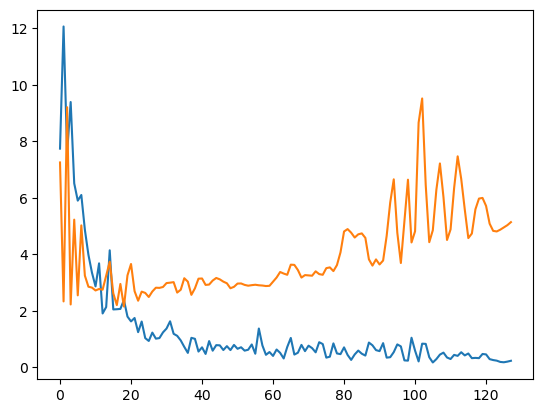

In [141]:
historial = historico.history
plt.plot(historial['loss'])
plt.plot(historial['val_loss'])

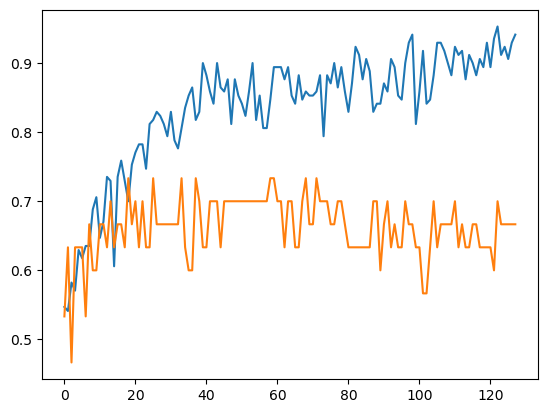

In [142]:
plt.plot(historial['acc'])
plt.plot(historial['val_acc'])

In [143]:
prediccion = model.predict(Xtest)
aciertos = np.sum(prediccion == ytest)
print(f'{aciertos/ytest.shape[0]*100 }%')

2/2 [==============================] - 0s 3ms/step
47.5%
